In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-02-03 19:01:14.703611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 19:01:14.868704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 19:01:14.868729: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03 19:01:15.868157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

2.11.0


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Explore os dados
> Vamos parar um momento para entender o formato dos dados. O conjunto de dados vem pré-processado: cada exemplo é um array de inteiros representando as palavras da avaliação do filme. Cada label é um inteiro com valor ou de 0 ou 1, onde 0 é uma avaliação negativa e 1 é uma avaliação positiva.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
# Um dicionário mapeando palavras em índices inteiros
word_index = imdb.get_word_index()

# Os primeiros índices são reservados
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [5]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare os dados
As avaliações —os arrays de inteiros— devem ser convertidas em tensores (tensors) antes de alimentar a rede neural. Essa conversão pode ser feita de duas formas:

- Converter os arrays em vetores de 0s e 1s indicando a ocorrência da palavra, similar com one-hot encoding. Por exemplo, a sequência [3, 5] se tornaria um vetor de 10000 dimensões, onde todos seriam 0s, tirando 3 e 5, que são 1s. Depois, faça disso a primeira camada da nossa rede neural — a Dense layer — que pode trabalhar com dados em ponto flutuante. Essa abordagem é intensa em relação a memória, logo requer uma matriz de tamanho num_words * num_reviews.

- Alternativamente, podemos preencher o array para que todos tenho o mesmo comprimento, e depois criar um tensor inteiro de formato max_length * num_reviews. Podemos usar uma camada embedding capaz de lidar com o formato como a primeira camada da nossa rede.

Nesse tutorial, usaremos a segunda abordagem.

Já que as avaliações dos filmes devem ter o mesmo tamanho, usaremos a função pad_sequences para padronizar os tamanhos:

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
# O formato de entrada é a contagem vocabulário usados pelas avaliações dos filmes (10000 palavras)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


2023-02-03 19:01:23.541271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-03 19:01:23.541331: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 19:01:23.541369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-02-03 19:01:23.541609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As camadas são empilhadas sequencialmente para construir o classificador:

1. A primeira camada é uma camada Embedding (Embedding layer). Essa camada pega o vocabulário em inteiros e olha o vetor embedding em cada palavra-index. Esses vetores são aprendidos pelo modelo, ao longo do treinamento. Os vetores adicionam a dimensão ao array de saída. As dimensões resultantes são: (batch, sequence, embedding).
2. Depois, uma camada GlobalAveragePooling1D retorna um vetor de saída com comprimento fixo para cada exemplo fazendo a média da sequência da dimensão. Isso permite o modelo de lidar com entradas de tamanhos diferentes da maneira mais simples possível.
3. Esse vetor de saída com tamanho fixo passa por uma camada fully-connected (Dense) layer com 16 hidden units.
4. A última camada é uma densely connected com um único nó de saída. Usando uma função de ativação sigmoid, esse valor é um float que varia entre 0 e 1, representando a probabilidade, ou nível de confiança.

## Hidden units
O modelo abaixo tem duas camadas intermediárias ou "hidden" (hidden layers), entre a entrada e saída. O número de saídas (unidades— units—, nós ou neurônios) é a dimensão do espaço representacional para a camada. Em outras palavras, a quantidade de liberdade que a rede é permitida enquanto aprende uma representação interna.

Se o modelo tem mais hidden units (um espaço representacional de maior dimensão), e/ou mais camadas, então a rede pode aprender representações mais complexas. Entretanto, isso faz com que a rede seja computacionalmente mais custosa e pode levar ao aprendizado de padrões não desejados— padrões que melhoram a performance com os dados de treinamento, mas não com os de teste. Isso se chama overfitting, e exploraremos mais tarde.

## Função Loss e otimizadores (optimizer)
O modelo precisa de uma função loss e um otimizador (optimizer) para treinamento. Já que é um problema de classificação binário e o modelo tem como saída uma probabilidade (uma única camada com ativação sigmoide), usaremos a função loss binary_crossentropy.

Essa não é a única escolha de função loss, você poderia escolher, no lugar, a mean_squared_error. Mas, geralmente, binary_crossentropy é melhor para tratar probabilidades— ela mede a "distância" entre as distribuições de probabilidade, ou, no nosso caso, sobre a distribuição real e as previsões.

Mais tarde, quando explorarmos problemas de regressão (como, predizer preço de uma casa), veremos como usar outra função loss chamada mean squared error.

Agora, configure o modelo para usar o optimizer a função loss:

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 38ms/step - loss: 0.6917 - accuracy: 0.5723 - val_loss: 0.6897 - val_accuracy: 0.5953
Epoch 2/40
30/30 [==============================] - 1s 29ms/step - loss: 0.6855 - accuracy: 0.7002 - val_loss: 0.6811 - val_accuracy: 0.6642
Epoch 3/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6706 - accuracy: 0.7411 - val_loss: 0.6609 - val_accuracy: 0.7480
Epoch 4/40
30/30 [==============================] - 1s 26ms/step - loss: 0.6430 - accuracy: 0.7749 - val_loss: 0.6302 - val_accuracy: 0.7677
Epoch 5/40
30/30 [==============================] - 1s 29ms/step - loss: 0.6044 - accuracy: 0.7945 - val_loss: 0.5913 - val_accuracy: 0.7884
Epoch 6/40
30/30 [==============================] - 1s 24ms/step - loss: 0.5581 - accuracy: 0.8159 - val_loss: 0.5470 - val_accuracy: 0.8034
Epoch 7/40
30/30 [==============================] - 1s 29ms/step - loss: 0.5091 - accuracy: 0.8328 - val_loss: 0.5028 - val_accuracy: 0.8210
Epoch 8/40
30

In [11]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3340 - accuracy: 0.8711 - 1s/epoch - 2ms/step
[0.3340199291706085, 0.8711199760437012]


In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

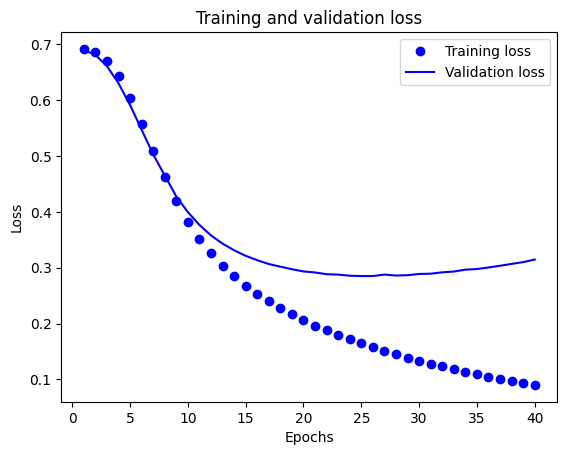

In [13]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

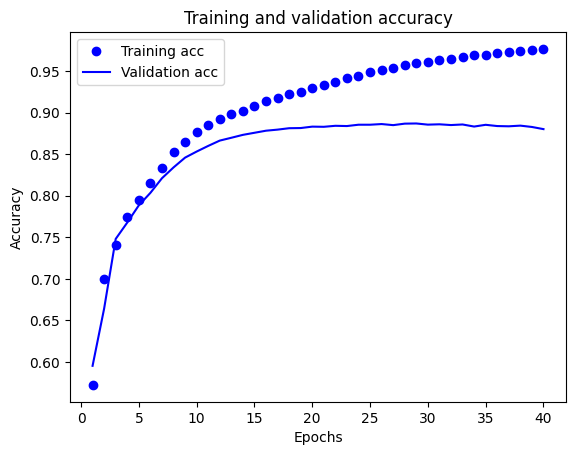

In [14]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

No gráfico, os pontos representam o loss e acurácia de treinamento, e as linhas são o loss e a acurácia de validação.

> Note: que o loss de treinamento diminui a cada epoch e a acurácia aumenta. Isso é esperado quando usado um gradient descent optimization—ele deve minimizar a quantidade desejada a cada iteração.

Esse não é o caso do loss e da acurácia de validação— eles parecem ter um pico depois de 20 epochs. Isso é um exemplo de overfitting: o modelo desempenha melhor nos dados de treinamento do que quando usado com dados nunca vistos. Depois desse ponto, o modelo otimiza além da conta e aprende uma representação especifica para os dados de treinamento e não generaliza para os dados de teste.

Para esse caso particular, podemos prevenir o overfitting simplesmente parando o treinamento após mais ou menos 20 epochs. Depois, você verá como fazer isso automaticamente com um callback.